In [1]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from keras.metrics import categorical_accuracy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf
# Warnings'ı gizle
warnings.filterwarnings("ignore")

In [2]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [3]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [4]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [5]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [6]:
# #### Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS, 3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)


# Birkaç yararlı değeri bildirme
epochs = 40
num_train_samples = train_samples_num
num_val_samples = val_samples_num
train_batch_size = 64
val_batch_size = 64
image_size = 224

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size

36529
3673


In [7]:
from tensorflow.keras.applications.densenet import preprocess_input
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path, # You might want to change this to a test_path if you have a separate test directory
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )

Found 36529 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.


In [8]:
# DenseNet121 modelini yükle (imagenet ağırlıklarıyla)
densenet_model = DenseNet121(input_shape=input_shape, weights='imagenet', include_top=False)

# Model katmanlarını güncelleme
x = densenet_model.output
x = GlobalAveragePooling2D()(x)           # Özellikleri sıkıştırmak için global ortalama havuzlama
x = Dropout(0.4)(x)                       # Overfitting'i azaltmak için %40 oranında dropout
x = Dense(1024, activation='relu')(x)     # 1024 nöronlu tam bağlantılı katman
x = Dense(512, activation='relu')(x)      # 512 nöronlu tam bağlantılı katman
x = Dense(512, activation='relu')(x)      # Bir başka 512 nöronlu tam bağlantılı katman
predictions = Dense(7, activation='softmax')(x)  # 7 sınıf için çıkış katmanı (softmax ile çok sınıflı sınıflandırma)

# Yeni model
model = tf.keras.Model(inputs=densenet_model.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,878,151 (33.87 MB)

 Trainable params: 8,794,503 (33.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
for layer in densenet_model.layers[:300]:  # İlk 300 katmanı dondurma
    layer.trainable = False
for layer in densenet_model.layers[300:]:  # Sonraki katmanları eğitilebilir hale getirme
    layer.trainable = True

In [10]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['categorical_accuracy'])

# Modelin kaydedileceği yolunu bildirme
filepath = "C:/Users/esraa/Desktop/base_dir/densenet_model.keras"


checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=4,
                              verbose=1,
                              mode='min',
                              min_lr=0.00001)

# Callback'leri listeye ekleme
callbacks_list = [checkpoint, reduce_lr]

In [11]:
# Modeli eğitme
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/40
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4883 - loss: 2.1684
Epoch 1: val_loss improved from inf to 3.62394, saving model to C:/Users/esraa/Desktop/base_dir/densenet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 3224s 6s/step - categorical_accuracy: 0.4886 - loss: 2.1666 - val_categorical_accuracy: 0.5093 - val_loss: 3.6239 - learning_rate: 0.0100
Epoch 2/40
  1/570 ━━━━━━━━━━━━━━━━━━━━ 47:47 5s/step - categorical_accuracy: 0.6875 - loss: 0.7963
Epoch 2: val_loss did not improve from 3.62394
570/570 ━━━━━━━━━━━━━━━━━━━━ 230s 395ms/step - categorical_accuracy: 0.6875 - loss: 0.7963 - val_categorical_accuracy: 0.4893 - val_loss: 4.1572 - learning_rate: 0.0100
Epoch 3/40
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.7876 - loss: 0.5927
Epoch 3: val_loss improved from 3.62394 to 1.01104, saving model to C:/Users/esraa/Desktop/base_dir/densenet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 3197s 6s/step - categorical_accuracy: 0.7877 - loss: 0.5

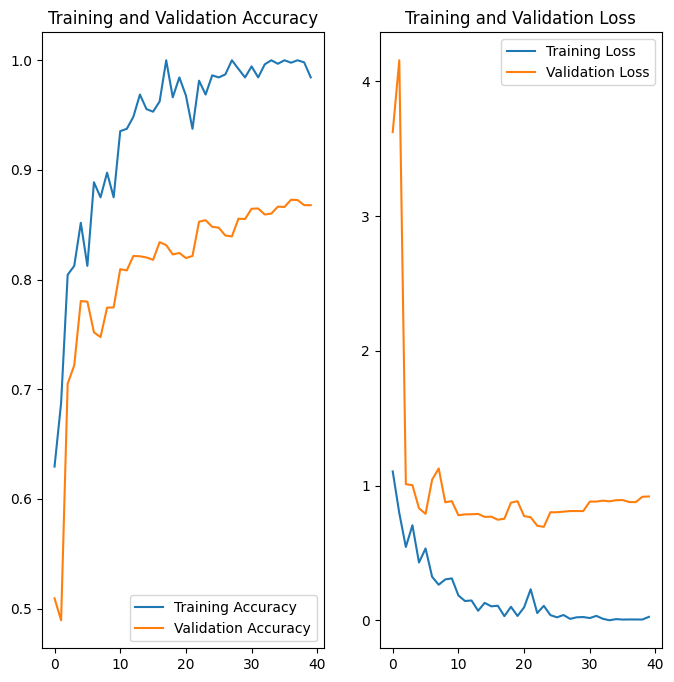

In [12]:
# Eğitim sonuçlarını görselleştirme
acc = history.history.get('categorical_accuracy', [])
val_acc = history.history.get('val_categorical_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


58/58 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step
Precision: 0.8707036658038011
Recall: 0.8679553498502587
F1 Score: 0.8677786581914287


In [14]:
# Modeli hesaplama
# Son dönümün hesabı
val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


# En iyi dönüm için hesaplama
model.load_weights(filepath)

57/57 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - categorical_accuracy: 0.8102 - loss: 1.5290
val_loss: 0.9216538071632385
val_cat_acc: 0.8673245906829834


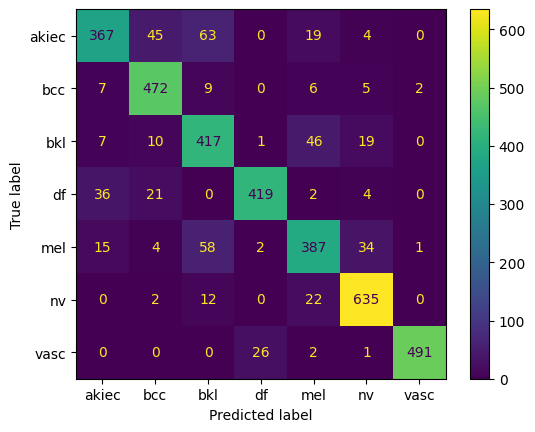

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step
Normalized Confusion Matrix
[[0.78714859 0.06827309 0.12449799 0.         0.01606426 0.00401606
  0.        ]
 [0.03592814 0.92215569 0.0239521  0.         0.00998004 0.00798403
  0.        ]
 [0.034      0.022      0.86       0.006      0.05       0.028
  0.        ]
 [0.05394191 0.06431535 0.02074689 0.85062241 0.00207469 0.00829876
  0.        ]
 [0.0758483  0.00399202 0.20558882 0.00199601 0.61477046 0.09580838
  0.00199601]
 [0.00149031 0.00298063 0.02682563 0.         0.01639344 0.95081967
  0.00149031]
 [0.         0.         0.00192308 0.03461538 0.         0.01153846
  0.95192308]]


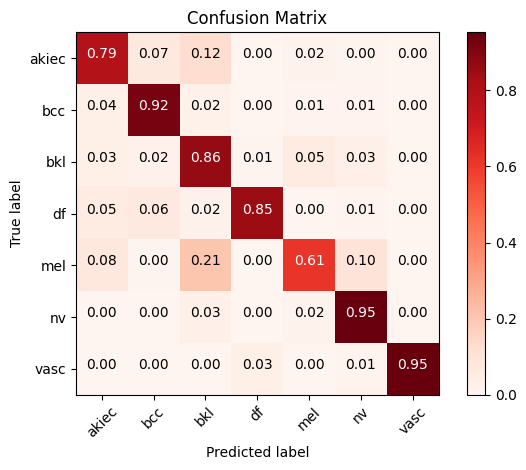

In [16]:
# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, test_batches.n//test_batches.batch_size+1, verbose=1)
predictions = np.argmax(predictions, axis=1)

# Confusion matrisi fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)


image shape: (224, 224, 3)


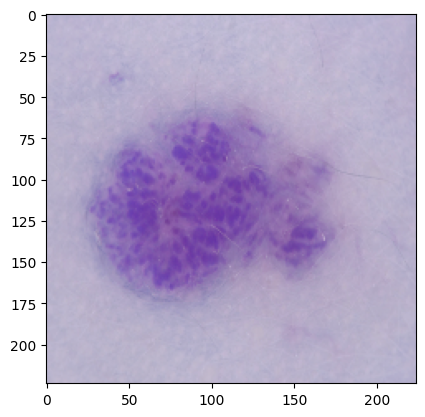

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.0048207  0.01645687 0.0284731  0.18871045 0.03071678 0.27831742
  0.4525047 ]]
vasc


In [17]:
import tensorflow as tf
# read sample test image
import cv2
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

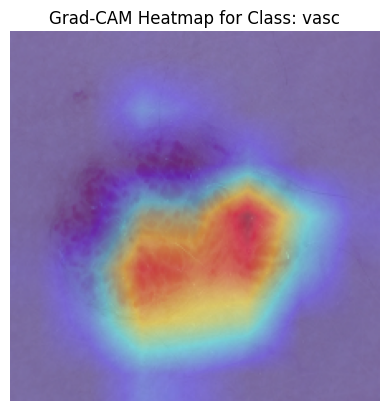

In [18]:
def grad_cam(model, img, layer_name, label_index):
    # Grad-CAM modeli
    grad_model = tf.keras.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, label_index]

    # Gradyanları hesaplama
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(conv_outputs, weights)

    # Normalize etme
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))

    return cam

# Grad-CAM için son konvolüsyonel katman
last_conv_layer_name = 'conv5_block16_concat'

# Grad-CAM hesaplama
heatmap = grad_cam(model, img_test, last_conv_layer_name, predicted_label)

# Orijinal görüntü üzerine ısı haritasını bindirme
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_scaled, 0.6, heatmap, 0.4, 0)

# Görselleştirme
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap for Class: {cm_plot_labels[predicted_label]}")
plt.axis('off')
plt.show()


In [19]:
import tensorflow as tf

# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/densenet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/densenet_model.h5")
